In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Machine learning models & preprocessing
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_recall_curve,
    auc,
    confusion_matrix,
    classification_report,
    recall_score
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

In [2]:
crashes = pd.read_csv("crashesClean.csv")

crashes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303606 entries, 0 to 303605
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ADDRESS               303606 non-null  object 
 1   LATITUDE              303606 non-null  float64
 2   LONGITUDE             303606 non-null  float64
 3   WARD                  303604 non-null  object 
 4   TOTAL_VEHICLES        303606 non-null  int64  
 5   TOTAL_BICYCLES        303606 non-null  int64  
 6   TOTAL_PEDESTRIANS     303606 non-null  int64  
 7   NEARESTINTSTREETNAME  303606 non-null  object 
 8   OFFINTERSECTION       303606 non-null  float64
 9   crash_datetime        303606 non-null  object 
 10  year                  303606 non-null  int64  
 11  month                 303606 non-null  int64  
 12  weekday               303606 non-null  object 
 13  fatalities            303606 non-null  float64
 14  majorinjuries         303606 non-null  float64
 15  

In [3]:
crashes.head()

,ADDRESS,LATITUDE,LONGITUDE,WARD,TOTAL_VEHICLES,TOTAL_BICYCLES,TOTAL_PEDESTRIANS,NEARESTINTSTREETNAME,OFFINTERSECTION,crash_datetime,year,month,weekday,fatalities,majorinjuries,minorinjuries,speeding,impaired,severity
0,800 KENILWORTH AVE NE,38.901131,-76.945592,Ward 7,1,0,0,JAY ST NE,65.63,2011-04-10 04:00:00+00:00,2011,4,Sunday,0.0,0.0,0.0,0,0,Property Damage Only
1,1100 13TH ST NW,38.904346,-77.030259,Ward 2,2,0,0,Unknown,0.00,2011-04-11 04:00:00+00:00,2011,4,Monday,0.0,0.0,0.0,0,0,Property Damage Only
2,1400 FIRST ST. NE,38.909074,-77.013661,Ward 5,2,0,0,Unknown,0.00,2011-04-12 04:00:00+00:00,2011,4,Tuesday,0.0,0.0,0.0,0,0,Property Damage Only
3,415 MICHIGAN AVE NE,38.931208,-76.999755,Ward 5,2,0,0,Unknown,0.00,2011-04-12 04:00:00+00:00,2011,4,Tuesday,0.0,0.0,1.0,0,0,Injury
4,3000 BLOCK OF SOUTH DAKOTA AVENUE NE,38.929546,-76.969746,Ward 5,3,0,0,IRVING ST NE,48.62,2011-04-13 04:00:00+00:00,2011,4,Wednesday,0.0,0.0,0.0,0,0,Property Damage Only


In [4]:
crashes['severity'].value_counts()

severity
Property Damage Only    219833
Injury                   83206
Fatal                      567
Name: count, dtype: int64

In [5]:
### Define binary target variable
crashes['severe'] = crashes['severity'].isin(['Injury', 'Fatal']).astype(int)

crashes['severe'].value_counts()

severe
0    219833
1     83773
Name: count, dtype: int64

In [6]:
crashes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303606 entries, 0 to 303605
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ADDRESS               303606 non-null  object 
 1   LATITUDE              303606 non-null  float64
 2   LONGITUDE             303606 non-null  float64
 3   WARD                  303604 non-null  object 
 4   TOTAL_VEHICLES        303606 non-null  int64  
 5   TOTAL_BICYCLES        303606 non-null  int64  
 6   TOTAL_PEDESTRIANS     303606 non-null  int64  
 7   NEARESTINTSTREETNAME  303606 non-null  object 
 8   OFFINTERSECTION       303606 non-null  float64
 9   crash_datetime        303606 non-null  object 
 10  year                  303606 non-null  int64  
 11  month                 303606 non-null  int64  
 12  weekday               303606 non-null  object 
 13  fatalities            303606 non-null  float64
 14  majorinjuries         303606 non-null  float64
 15  

In [7]:
# Data Preparation for CatBoost
# Create copy of 'crashes' 
crashes1 = crashes.copy()

### Extract numeric info from 'crash_datetime' column
crashes1['crash_datetime'] = pd.to_datetime(crashes1['crash_datetime'], errors='coerce')

crashes1['hour'] = crashes1['crash_datetime'].dt.hour
crashes1['dayofyear'] = crashes1['crash_datetime'].dt.dayofyear
crashes1['is_night'] = crashes1['hour'].between(0, 5).astype(int)

crashes1 = crashes1.drop(columns=['crash_datetime'])

### Drop columns that could "leak" data 
crashes1 = crashes1.drop(columns=[
    'fatalities', 'majorinjuries', 'minorinjuries', 'severity'
])

### Handle missing values (categorical & numerical)
cat_cols = ['WARD', 'weekday', 'NEARESTINTSTREETNAME', 'ADDRESS', 'is_night']

for col in cat_cols:
    crashes1[col] = crashes1[col].fillna('Unknown')

num_cols = [
    'LATITUDE', 'LONGITUDE', 'TOTAL_VEHICLES',
    'TOTAL_BICYCLES', 'TOTAL_PEDESTRIANS',
    'OFFINTERSECTION', 'year', 'month', 'hour'
]

crashes1[num_cols] = crashes1[num_cols].fillna(crashes1[num_cols].median())


### Transform less common street names --> 'OTHER'
street_counts = crashes1['NEARESTINTSTREETNAME'].value_counts()
rare_streets = street_counts[street_counts < 50].index

crashes1['NEARESTINTSTREETNAME'] = crashes1['NEARESTINTSTREETNAME'].replace(
    rare_streets, 'OTHER'
)

crashes1.head(10)

,ADDRESS,LATITUDE,LONGITUDE,WARD,TOTAL_VEHICLES,TOTAL_BICYCLES,TOTAL_PEDESTRIANS,NEARESTINTSTREETNAME,OFFINTERSECTION,year,month,weekday,speeding,impaired,severe,hour,dayofyear,is_night
0,800 KENILWORTH AVE NE,38.901131,-76.945592,Ward 7,1,0,0,JAY ST NE,65.63,2011,4,Sunday,0,0,0,4,100,1
1,1100 13TH ST NW,38.904346,-77.030259,Ward 2,2,0,0,Unknown,0.00,2011,4,Monday,0,0,0,4,101,1
2,1400 FIRST ST. NE,38.909074,-77.013661,Ward 5,2,0,0,Unknown,0.00,2011,4,Tuesday,0,0,0,4,102,1
3,415 MICHIGAN AVE NE,38.931208,-76.999755,Ward 5,2,0,0,Unknown,0.00,2011,4,Tuesday,0,0,1,4,102,1
4,3000 BLOCK OF SOUTH DAKOTA AVENUE NE,38.929546,-76.969746,Ward 5,3,0,0,IRVING ST NE,48.62,2011,4,Wednesday,0,0,0,4,103,1
5,54 OBSERVATORY CIRCLE,38.923108,-77.070029,Ward 3,2,0,0,CALVERT ST NW,70.02,2011,4,Thursday,0,0,1,4,104,1
6,700 BLK KENNILWORTH AVE NE,38.900871,-76.945918,Ward 7,2,0,0,0 Intersecting RouteID Not Found,0.00,2011,4,Thursday,0,0,0,4,104,1
7,"5005 14TH ST., NE",38.950467,-76.985662,Ward 5,1,0,0,OTHER,18.44,2011,4,Friday,0,0,0,4,105,1
8,4100 MARTIN LUTHER KING JR AVE SW,38.829546,-77.011986,Ward 8,2,0,0,OTHER,9.65,2011,4,Thursday,0,0,0,4,104,1
9,"1600 15 ST, NW",38.911126,-77.034809,Ward 2,2,0,0,15TH ST NW,21.96,2011,4,Sunday,0,0,1,4,107,1


In [8]:
### Train/val/test split
X = crashes1.drop(columns=['severe'])
y = crashes1['severe']

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=47
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=47
)


In [9]:
### Encode Categorical columns w/ ordinality
encoder = OrdinalEncoder(
    handle_unknown='use_encoded_value',
    unknown_value=-1
)

X_train[cat_cols] = encoder.fit_transform(X_train[cat_cols])
X_val[cat_cols] = encoder.transform(X_val[cat_cols])
X_test[cat_cols] = encoder.transform(X_test[cat_cols])

### Scale numeric features
scaler = StandardScaler()

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val[num_cols] = scaler.transform(X_val[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

X_train.dtypes


ADDRESS                 float64
LATITUDE                float64
LONGITUDE               float64
WARD                    float64
TOTAL_VEHICLES          float64
TOTAL_BICYCLES          float64
TOTAL_PEDESTRIANS       float64
NEARESTINTSTREETNAME    float64
OFFINTERSECTION         float64
year                    float64
month                   float64
weekday                 float64
speeding                  int64
impaired                  int64
hour                    float64
dayofyear                 int32
is_night                float64
dtype: object

In [10]:
### Convert to numpy for TabNet

X_train_tab = X_train.to_numpy().astype(np.float32)
X_val_tab = X_val.to_numpy().astype(np.float32)
X_test_tab = X_test.to_numpy().astype(np.float32)

y_train_tab = y_train.to_numpy().astype(np.int64)
y_val_tab = y_val.to_numpy().astype(np.int64)
y_test_tab = y_test.to_numpy().astype(np.int64)

In [11]:
# Model Preparation: CatBoost
# Copy original dataframe 
crashes2 = crashes.copy()

# Drop severity column since severe exists (binary)
crashes2 = crashes2.drop(columns=["severity"])

# Drop columns that could leak data
crashes2 = crashes2.drop(columns=[
    "fatalities",
    "majorinjuries",
    "minorinjuries"
])

# Convert crash_datetime to datetime dtype
crashes2["crash_datetime"] = pd.to_datetime(crashes2["crash_datetime"], errors="coerce")

# Extract usable features
crashes2["hour"] = crashes2["crash_datetime"].dt.hour
crashes2["dayofweek"] = crashes2["crash_datetime"].dt.dayofweek

# Drop raw datetime to avoid errors
crashes2 = crashes2.drop(columns=["crash_datetime"])

# Convert numeric-like object columns safely
for col in crashes2.columns:
    if crashes2[col].dtype == "object":
        # try numeric conversion where appropriate
        crashes2[col] = pd.to_numeric(crashes2[col], errors="ignore")

# Convert empty strings or " " to NaN
crashes2 = crashes2.replace(r"^\s*$", np.nan, regex=True)

cat_cols = crashes2.select_dtypes(include=["object"]).columns.tolist()
print("Categorical features:", cat_cols)

# Verify columns treated correctly
print(crashes2.info())

# Verify 'severe' column is binary 
# 0    ~220k
# 1    ~83k + 567
print(crashes2["severe"].value_counts(dropna=False))

/var/folders/rl/6mrqzg_d1cvg3699yh85hvqm0000gp/T/ipykernel_80018/2125337775.py:29: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  crashes2[col] = pd.to_numeric(crashes2[col], errors="ignore")


Categorical features: ['ADDRESS', 'WARD', 'NEARESTINTSTREETNAME', 'weekday']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303606 entries, 0 to 303605
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ADDRESS               303606 non-null  object 
 1   LATITUDE              303606 non-null  float64
 2   LONGITUDE             303606 non-null  float64
 3   WARD                  303604 non-null  object 
 4   TOTAL_VEHICLES        303606 non-null  int64  
 5   TOTAL_BICYCLES        303606 non-null  int64  
 6   TOTAL_PEDESTRIANS     303606 non-null  int64  
 7   NEARESTINTSTREETNAME  303606 non-null  object 
 8   OFFINTERSECTION       303606 non-null  float64
 9   year                  303606 non-null  int64  
 10  month                 303606 non-null  int64  
 11  weekday               303606 non-null  object 
 12  speeding              303606 non-null  int64  
 13  impaired              30360

In [12]:
# Recompute categorical columns (after leakage removal)
cat_cols = crashes2.select_dtypes(include=["object"]).columns.tolist()

# Fill NaN with string placeholder
crashes2[cat_cols] = crashes2[cat_cols].fillna("Unknown")

# Ensure all categorical columns are string dtype
crashes2[cat_cols] = crashes2[cat_cols].astype(str)

print("Categorical NaNs handled?")
print(crashes2[cat_cols].isna().sum())


Categorical NaNs handled?
ADDRESS                 0
WARD                    0
NEARESTINTSTREETNAME    0
weekday                 0
dtype: int64


In [13]:
# Prepare data 
cat_cols = crashes2.select_dtypes(include=["object"]).columns.tolist()

# Ensure categorical NaNs are handled
crashes2[cat_cols] = crashes2[cat_cols].fillna("Unknown").astype(str)

X2 = crashes2.drop(columns=["severe"])
y2 = crashes2["severe"]

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X2, y2,
    test_size=0.2,
    stratify=y2,
    random_state=42
)

# Class weights for imbalanced target 
class_weights = [
    1,
    (y_train2 == 0).sum() / (y_train2 == 1).sum()
]

# Train CatBoost with tuned hyperparameters 
model = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="PRAUC",   # PR-AUC for imbalanced data
    depth=9,               # increased from 6
    learning_rate=0.02,    # decreased from 0.05 for more stable training
    iterations=1500,       # increased from 800
    class_weights=class_weights,
    cat_features=cat_cols,
    verbose=100
)

model.fit(
    X_train2, y_train2,
    eval_set=(X_test2, y_test2),
    early_stopping_rounds=50
)

# Predictions with threshold tuning
# Default threshold = 0.5, tuned to 0.35 to prioritize catching severe crashes
y2_proba = model.predict_proba(X_test2)[:, 1]
threshold = 0.35
y2_pred = (y2_proba >= threshold).astype(int)


0:	learn: 0.7136258	test: 0.7112568	best: 0.7112568 (0)	total: 156ms	remaining: 3m 53s
100:	learn: 0.7287155	test: 0.7238226	best: 0.7238226 (100)	total: 8.97s	remaining: 2m 4s
200:	learn: 0.7348585	test: 0.7273999	best: 0.7273999 (200)	total: 17.6s	remaining: 1m 54s
300:	learn: 0.7385336	test: 0.7285229	best: 0.7285229 (300)	total: 26s	remaining: 1m 43s
400:	learn: 0.7418937	test: 0.7293085	best: 0.7293085 (400)	total: 34.5s	remaining: 1m 34s
500:	learn: 0.7451197	test: 0.7297379	best: 0.7297379 (500)	total: 43.2s	remaining: 1m 26s
600:	learn: 0.7479063	test: 0.7301141	best: 0.7301149 (599)	total: 51.9s	remaining: 1m 17s
700:	learn: 0.7518073	test: 0.7306370	best: 0.7306467 (697)	total: 1m 1s	remaining: 1m 9s
800:	learn: 0.7561086	test: 0.7311176	best: 0.7311176 (800)	total: 1m 10s	remaining: 1m 1s
900:	learn: 0.7599076	test: 0.7315122	best: 0.7315133 (899)	total: 1m 20s	remaining: 53.2s
1000:	learn: 0.7636192	test: 0.7317188	best: 0.7317205 (999)	total: 1m 29s	remaining: 44.6s
1100:	

AUC-PR: 0.5413
Recall (Severe=1) at threshold 0.35: 0.8879
Confusion Matrix:
[[13095 30872]
 [ 1878 14877]]
Classification Report:
               precision    recall  f1-score   support

         PDO       0.87      0.30      0.44     43967
      Severe       0.33      0.89      0.48     16755

    accuracy                           0.46     60722
   macro avg       0.60      0.59      0.46     60722
weighted avg       0.72      0.46      0.45     60722



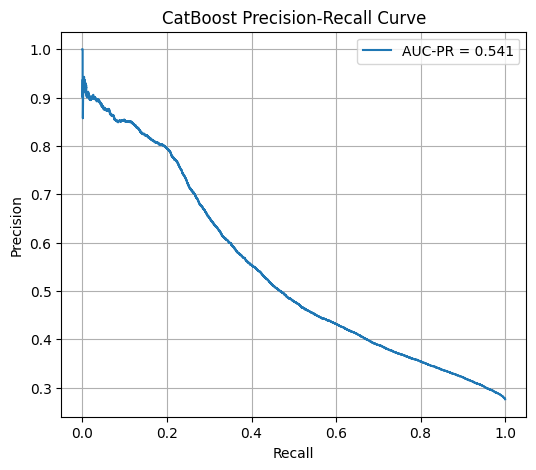

Top 10 Features by Importance:
             Feature Id  Importances
0     TOTAL_PEDESTRIANS    18.534170
1                  year    10.442278
2  NEARESTINTSTREETNAME     8.839061
3        TOTAL_VEHICLES     8.039047
4       OFFINTERSECTION     7.207779
5               ADDRESS     7.202638
6        TOTAL_BICYCLES     7.108162
7             LONGITUDE     6.751328
8              LATITUDE     6.642776
9                  WARD     5.464877


In [14]:
# Evaluate Results (PRAUC)
precision, recall, _ = precision_recall_curve(y_test2, y2_proba)
auc_pr = auc(recall, precision)
print(f"AUC-PR: {auc_pr:.4f}")

# Recall for severe crashes
recall_severe = recall_score(y_test2, y2_pred)
print(f"Recall (Severe=1) at threshold {threshold}: {recall_severe:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test2, y2_pred)
print("Confusion Matrix:")
print(cm)

# Classification Report
report = classification_report(y_test2, y2_pred, target_names=["PDO", "Severe"])
print("Classification Report:\n", report)

# Precision-Recall Curve
plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"AUC-PR = {auc_pr:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("CatBoost Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

# Feature Importance 
feature_importances = model.get_feature_importance(prettified=True)
print("Top 10 Features by Importance:")
print(feature_importances.head(10))


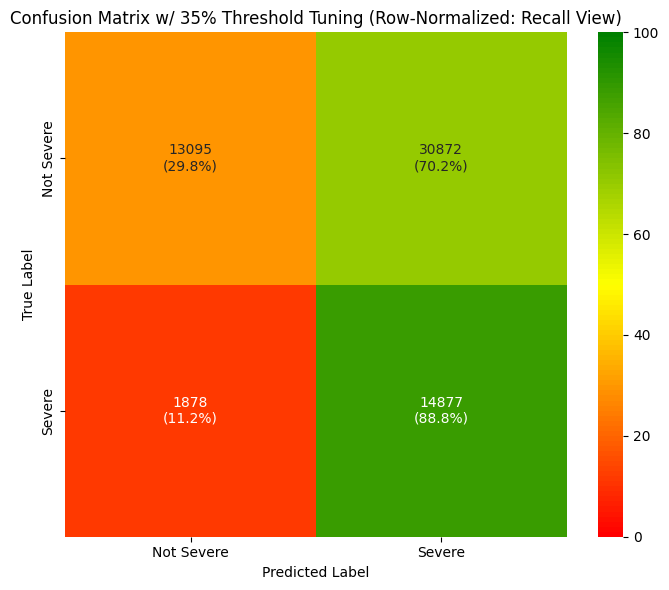

In [15]:
# Class labels 
labels = ["Not Severe", "Severe"]

# Compute raw confusion matrix
cm = confusion_matrix(y_test2, y2_pred)

# Row-wise normalization (percent within true class)
cm_row_percent = cm / cm.sum(axis=1, keepdims=True) * 100

# Create annotation text: count + percent
annot_text = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annot_text[i, j] = f"{cm[i, j]}\n({cm_row_percent[i, j]:.1f}%)"

# Red → Green colormap
red_green = LinearSegmentedColormap.from_list(
    "red_green", ["red", "yellow", "green"], N=100
)

# Plot heatmap
plt.figure(figsize=(7,6))
sns.heatmap(
    cm_row_percent,
    annot=annot_text,
    fmt="",
    cmap=red_green,
    vmin=0,
    vmax=100,
    cbar=True,
    xticklabels=labels,
    yticklabels=labels
)

plt.title("Confusion Matrix w/ 35% Threshold Tuning (Row-Normalized: Recall View)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


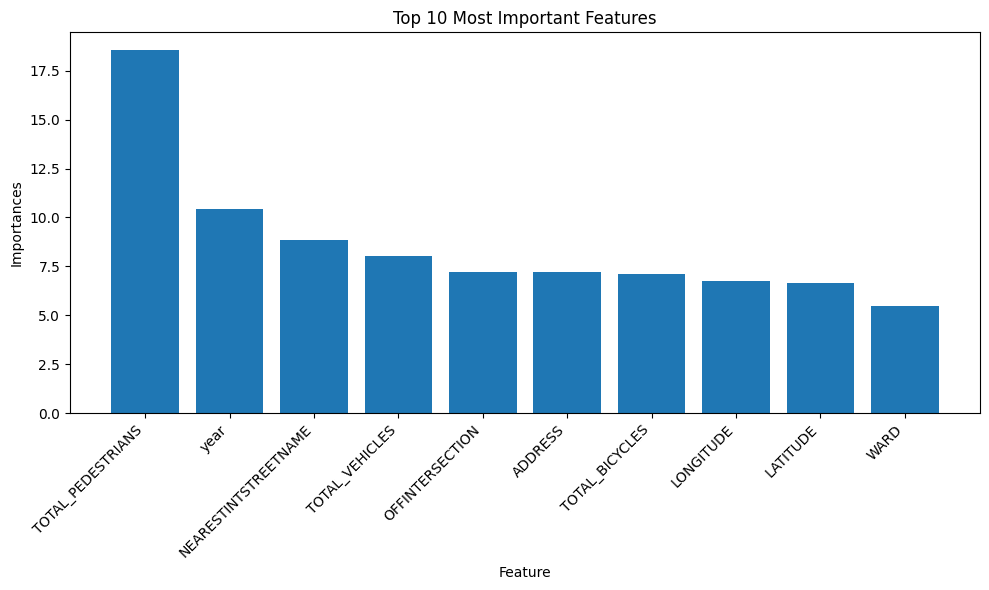

In [16]:
# Sort and select top 10 features
top10 = feature_importances.sort_values(
    by="Importances", ascending=False
).head(10)

# Plot
plt.figure(figsize=(10,6))
plt.bar(top10["Feature Id"], top10["Importances"])

plt.title("Top 10 Most Important Features")
plt.xlabel("Feature")
plt.ylabel("Importances")

# Rotate labels for readability
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


In [17]:
# Predict probabilities and thresholded labels 
y_proba = model.predict_proba(X_test2)[:, 1]  # probability of severe crashes
threshold = 0.35  # your tuned threshold
y_pred = (y_proba >= threshold).astype(int)

# Compute metrics
accuracy = accuracy_score(y_test2, y_pred)
f1 = f1_score(y_test2, y_pred)

precision, recall, _ = precision_recall_curve(y_test2, y_proba)
prauc = auc(recall, precision)

# Print results 
print(f"CatBoost Model Metrics:")
print(f"Accuracy: {accuracy:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"PRAUC: {prauc:.3f}")


CatBoost Model Metrics:
Accuracy: 0.461
F1 Score: 0.476
PRAUC: 0.541
